## The Training

### 1st train

Runs with data digit images only.
The best model will be stored as "cnn-s1-md-best.h5"


## The Model

Used a the jomjol CNN-S1 network as small model.



In [1]:
########### Basic Parameters for Running: ################################
    
Training_Percentage = 0.2           
Epoch_Anz = 400                     # earlystopping, see model.fit
nb_classes = 100                     # move to 1. step
#input_shape = (32, 20,1)            # will be calculated
Batch_Size = 8
use_grayscale = False                # grayscale or rgb
output_dir = "output/"
output_tmp_dir = "output/tmp/"
model_filename = "dig-class100-s1"

##########################################################################

from sklearn.model_selection import train_test_split
from b2n.data.tmnist import tmnist_percentals
from b2n.data.ziffer import ziffer_data
from b2n.plotfunctions import *
from sklearn.utils import shuffle
from b2n.encodings.class_encoding import *
from b2n.augmentation.generator import *
from datetime import datetime
import sys

date_time = datetime.now().strftime("%Y%m%d-%H%M%S")

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Tensorflow-Version: ", tf.__version__)
print("Python:", sys.version)


    # Disable all GPUS
#    tf.config.set_visible_devices([], 'GPU')
#    visible_devices = tf.config.get_visible_devices()
#    for device in visible_devices:
#        assert device.device_type != 'GPU'
#except:
    # Invalid device or cannot modify virtual devices once initialized.
#    pass

Num GPUs Available:  1
Tensorflow-Version:  2.16.2
Python: 3.11.14 | packaged by conda-forge | (main, Oct 22 2025, 22:56:31) [Clang 19.1.7 ]


## Load data

Like the distillation network meter digits will be trained with font builded images.

### digit meter images

The meter digits are all 0-9 ziffer_raw (https://github.com/jomjol/neural-network-autotrain-digital-counter/tree/main/ziffer_raw) and other collected data (used https://github.com/haverland/collectmeterdigits).

### Train and Test data

For 1st train the digit meter will be used.

### digit meter spread

The images of digit meters are collected and labeled by hand. So the image count of labels are differnt. The meter digit spread plot shows the count for each label.

Ziffer data count:  27217
dataset x_train-size=27217


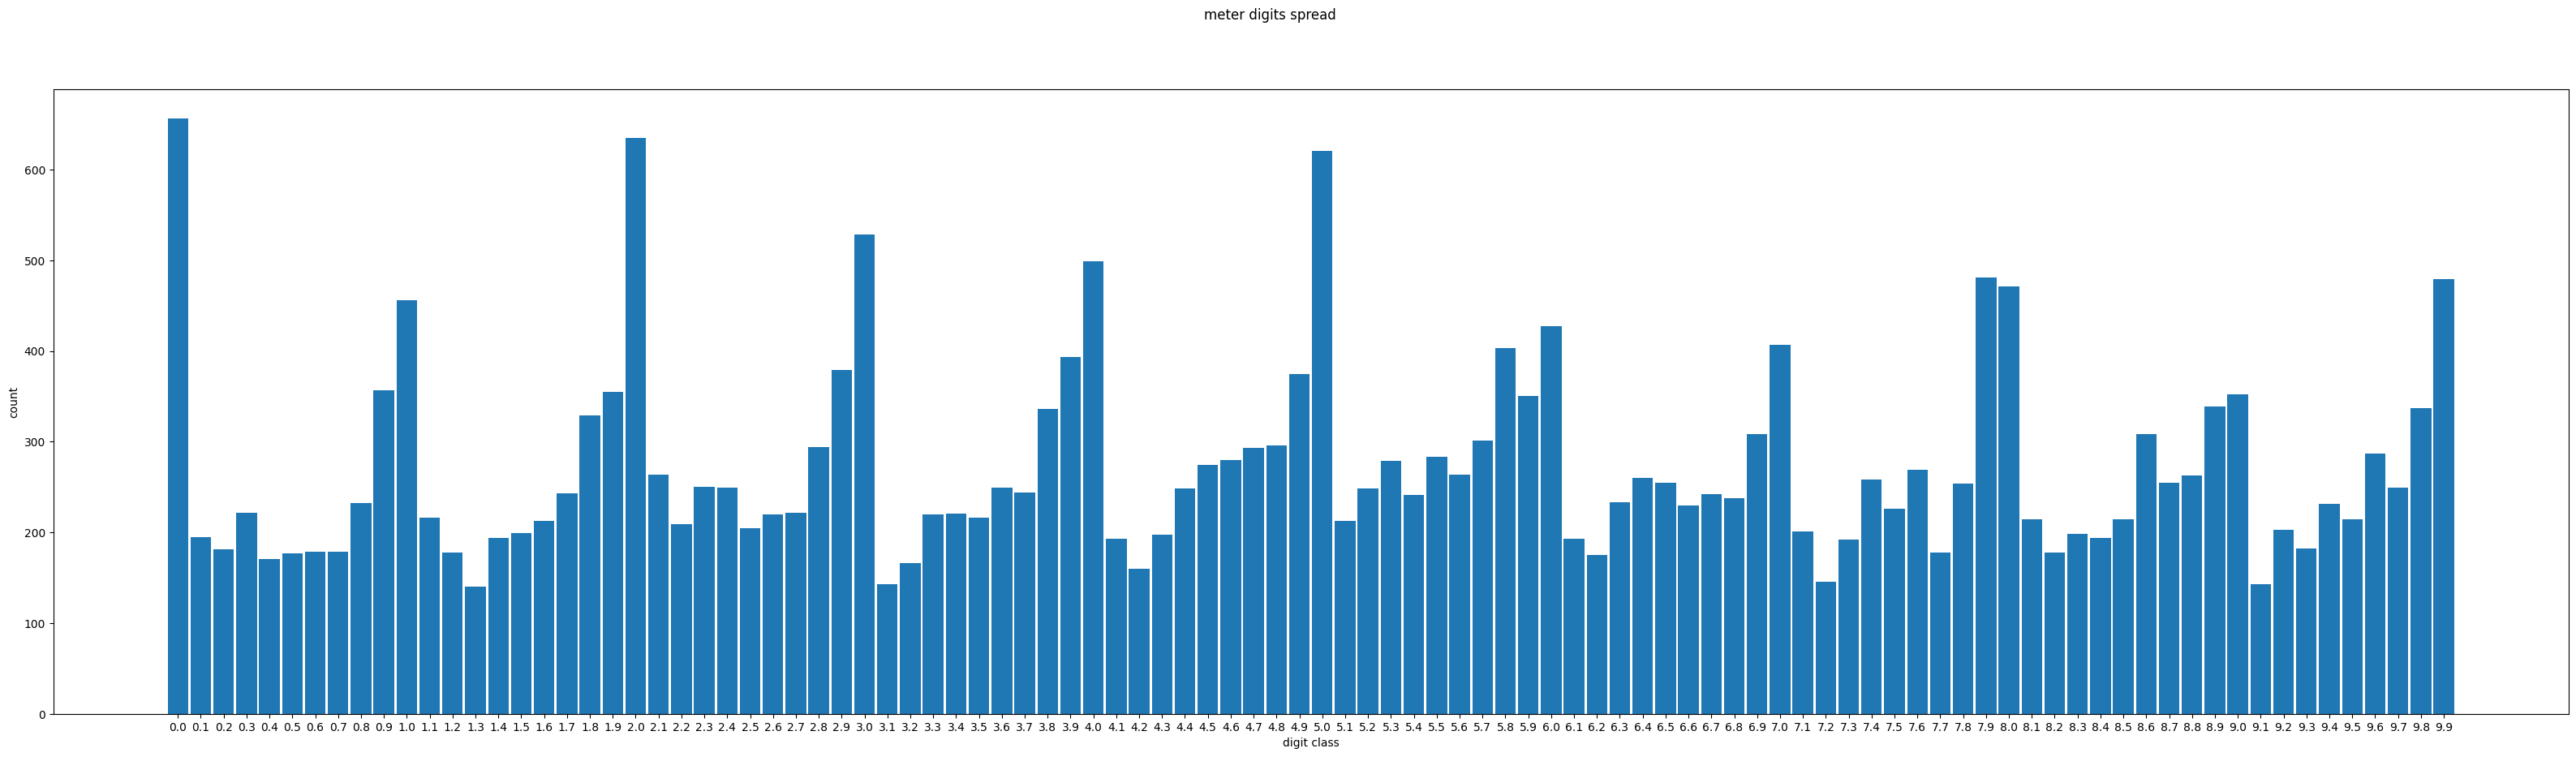

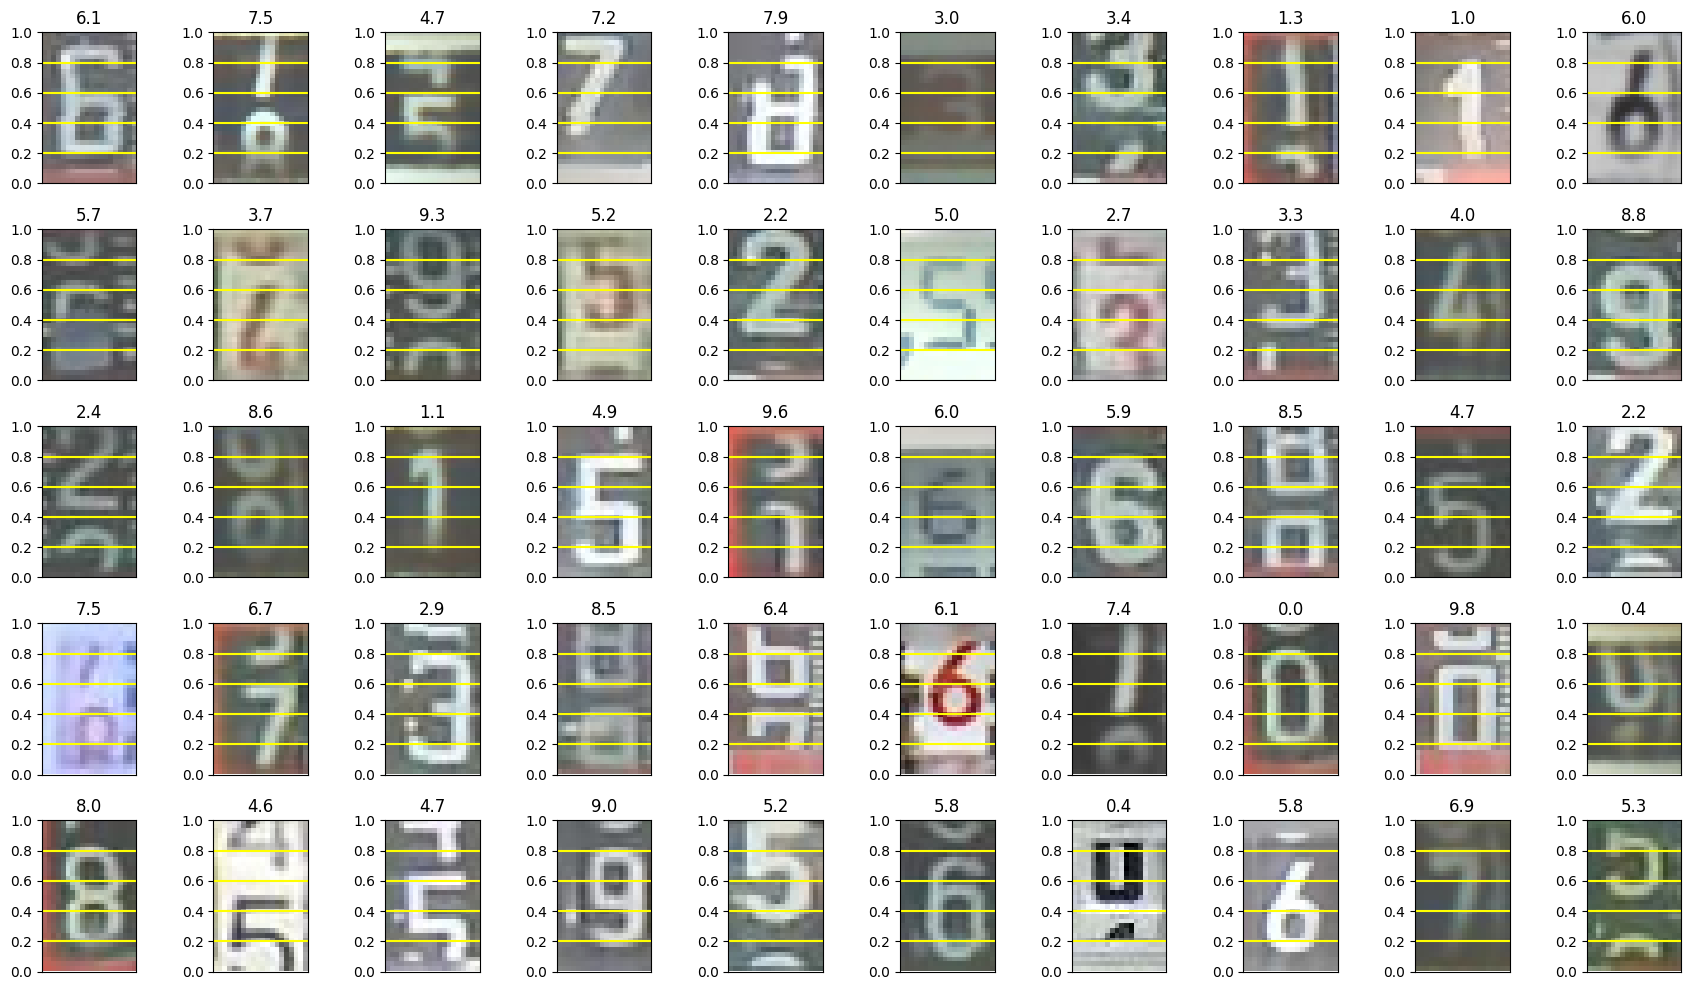

In [2]:


xz_data, yz_data, fz_data = ziffer_data(input_dir='images')

# distribution
_, inverse = np.unique(yz_data, return_inverse=True)
ziffer_bincount = np.bincount(inverse)
plot_divergence(ziffer_bincount, "meter digits spread", nb_classes)


# Split train and validation data 
xz_train, yz_train = shuffle(xz_data, yz_data)
x_train, x_test, y_train, y_test = train_test_split(xz_train, yz_train, test_size=Training_Percentage)

input_shape=xz_train[0].shape
print(f"dataset x_train-size={len(xz_train)}")
plot_dataset(xz_train, yz_train)

y_train = class_encoding(y_train, nb_classes)
y_test = class_encoding(y_test, nb_classes)


### Augmentation
See augementation above for augmentation values.
Standard augmentation of image generator is used plus inverting and noising images.

The validation set is not augmentated. It uses only meter digit images for a real result how the model fits to meter digits.
So the validation says more about the results and its easier to use a early stopping mechanism.

2025-10-28 21:33:37.995438: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-10-28 21:33:37.995470: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-10-28 21:33:37.995473: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-10-28 21:33:37.995491: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-28 21:33:37.995503: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Train data


2025-10-28 21:33:38.314853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


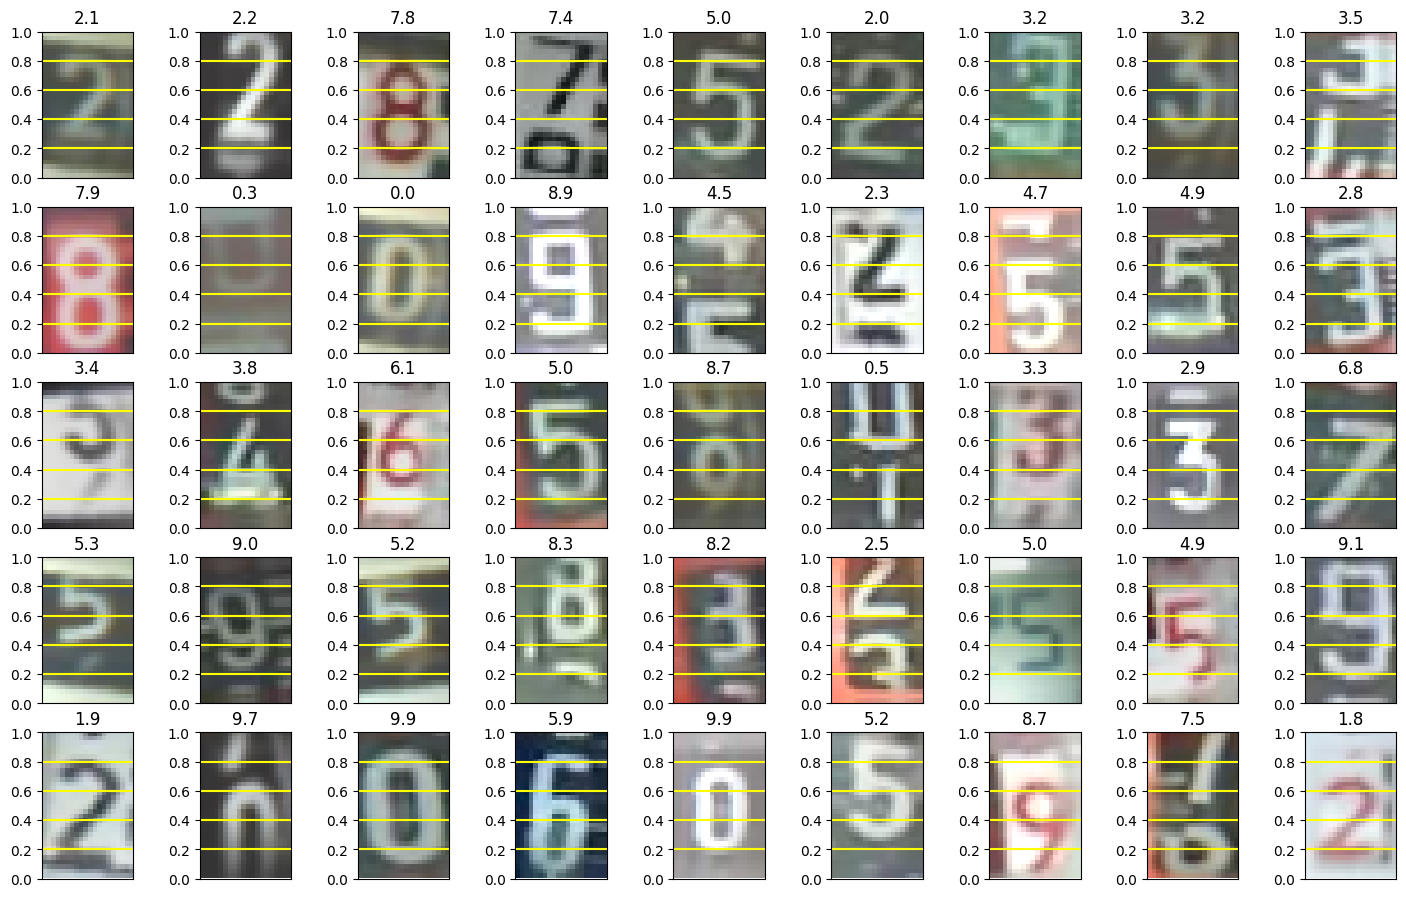

Validation data


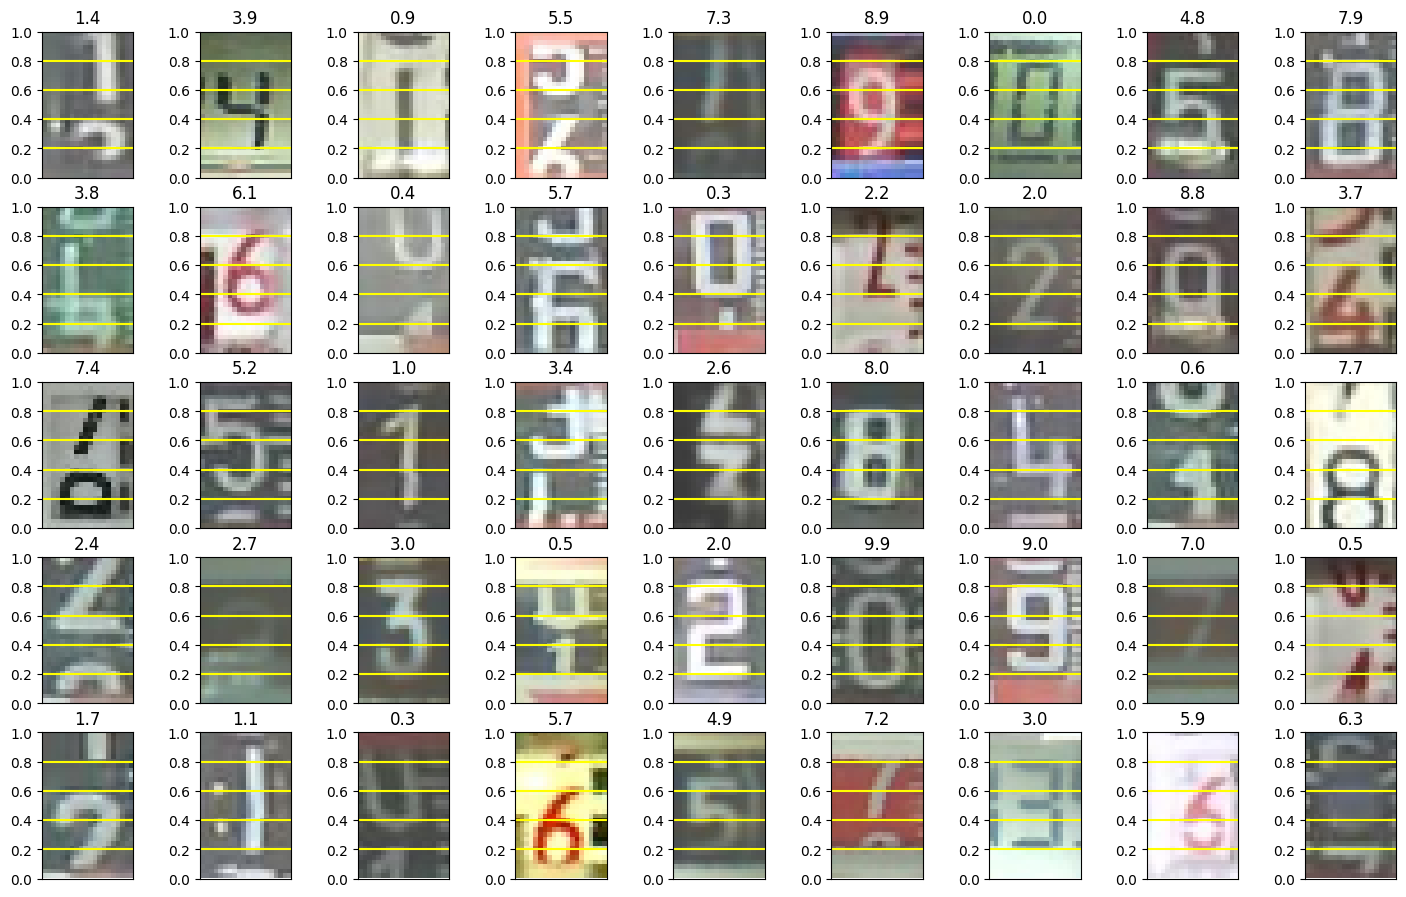

In [3]:
import numpy as np
from b2n.plotfunctions import plot_dataset_ds


preprocessing = tf.keras.Sequential([
        tf.keras.layers.RandomZoom([-.1, .1]),
        tf.keras.layers.RandomRotation((-0.02, 0.02)),
        tf.keras.layers.RandomContrast(0.1),
        tf.keras.layers.RandomBrightness(0.1),
        #tf.keras.layers.RandomTranslation(0.1, 0.1)
        ])

datagen = tf.data.Dataset.from_tensor_slices((x_train, y_train))
datagen = datagen.map(lambda x, y: (preprocessing(x), y),
		 num_parallel_calls=tf.data.AUTOTUNE)

# train data
print("Train data")
plot_dataset_ds(datagen)

# validation data
print("Validation data")
plot_dataset_ds(tf.data.Dataset.from_tensor_slices((x_test, y_test)))

train_iterator = datagen.cache().batch(Batch_Size).prefetch(tf.data.AUTOTUNE)
validation_iterator = tf.data.Dataset.from_tensor_slices((x_test, y_test)).cache().batch(Batch_Size).prefetch(tf.data.AUTOTUNE)


### The Model

Is an small EfficientNet like model with a dense output of 100 at top. 



In [4]:
import tensorflow as tf
from b2n.models.cnn32 import *

model = CNN_s1d(input_shape, nb_classes, activation_top=None)

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), metrics = ["accuracy"])
model.summary()

/opt/homebrew/Caskroom/miniforge/base/envs/tf217/lib/python3.11/site-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 32, 20, 3)      │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 20, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 20, 64)     │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 20, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 5, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 5, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 5, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,944 (534.94 KB)

 Trainable params: 136,618 (533.66 KB)

 Non-trainable params: 326 (1.27 KB)

### The Training

Standard training of the model with complete dataset.

The ModelCheckpoint helps to keep the best model. 

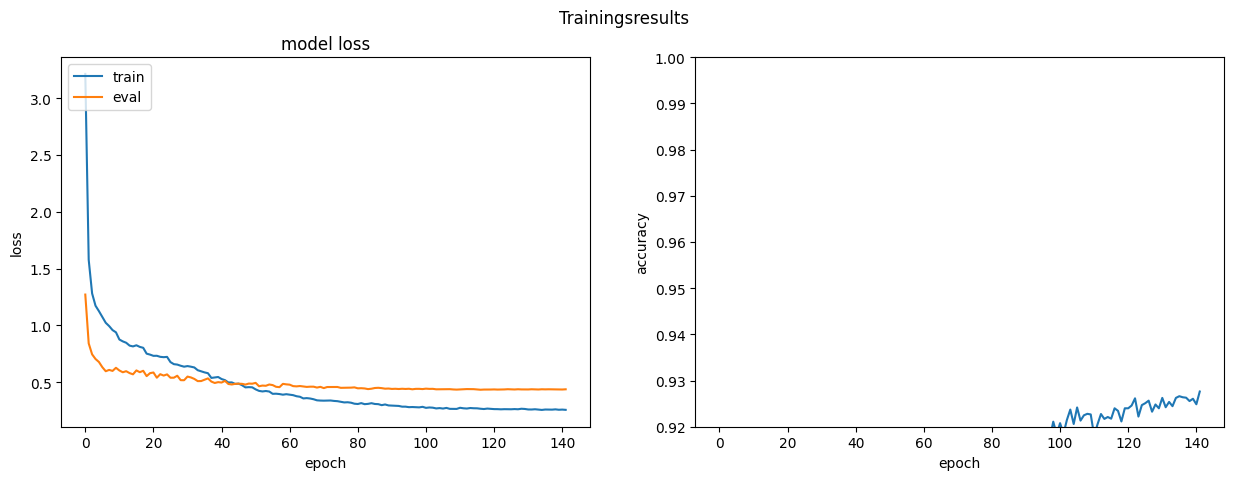

In [5]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from b2n.plotfunctions import plot_acc_loss, predict_meter_digits
tf.config.run_functions_eagerly(True)

earlystop = EarlyStopping(monitor='val_loss', mode='min' , patience=25, verbose=0,  restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.85, patience=3, min_lr=1e-5, verbose=0)
history = model.fit(train_iterator, 
                validation_data=validation_iterator, 
                batch_size=Batch_Size, 
                epochs = Epoch_Anz,
                callbacks=[earlystop, reduce_lr],
                verbose=0)

plot_acc_loss(history, "Trainingsresults")

### Validate on all digit meter

Because of the small dataset of meter digits all meter digits are used for validation. The first false predicted will be shown in the diagram.

/opt/homebrew/Caskroom/miniforge/base/envs/tf217/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


851/851 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step
Tested images: 27217. 96 false predicted. Accuracy is: 0.9964727927398317


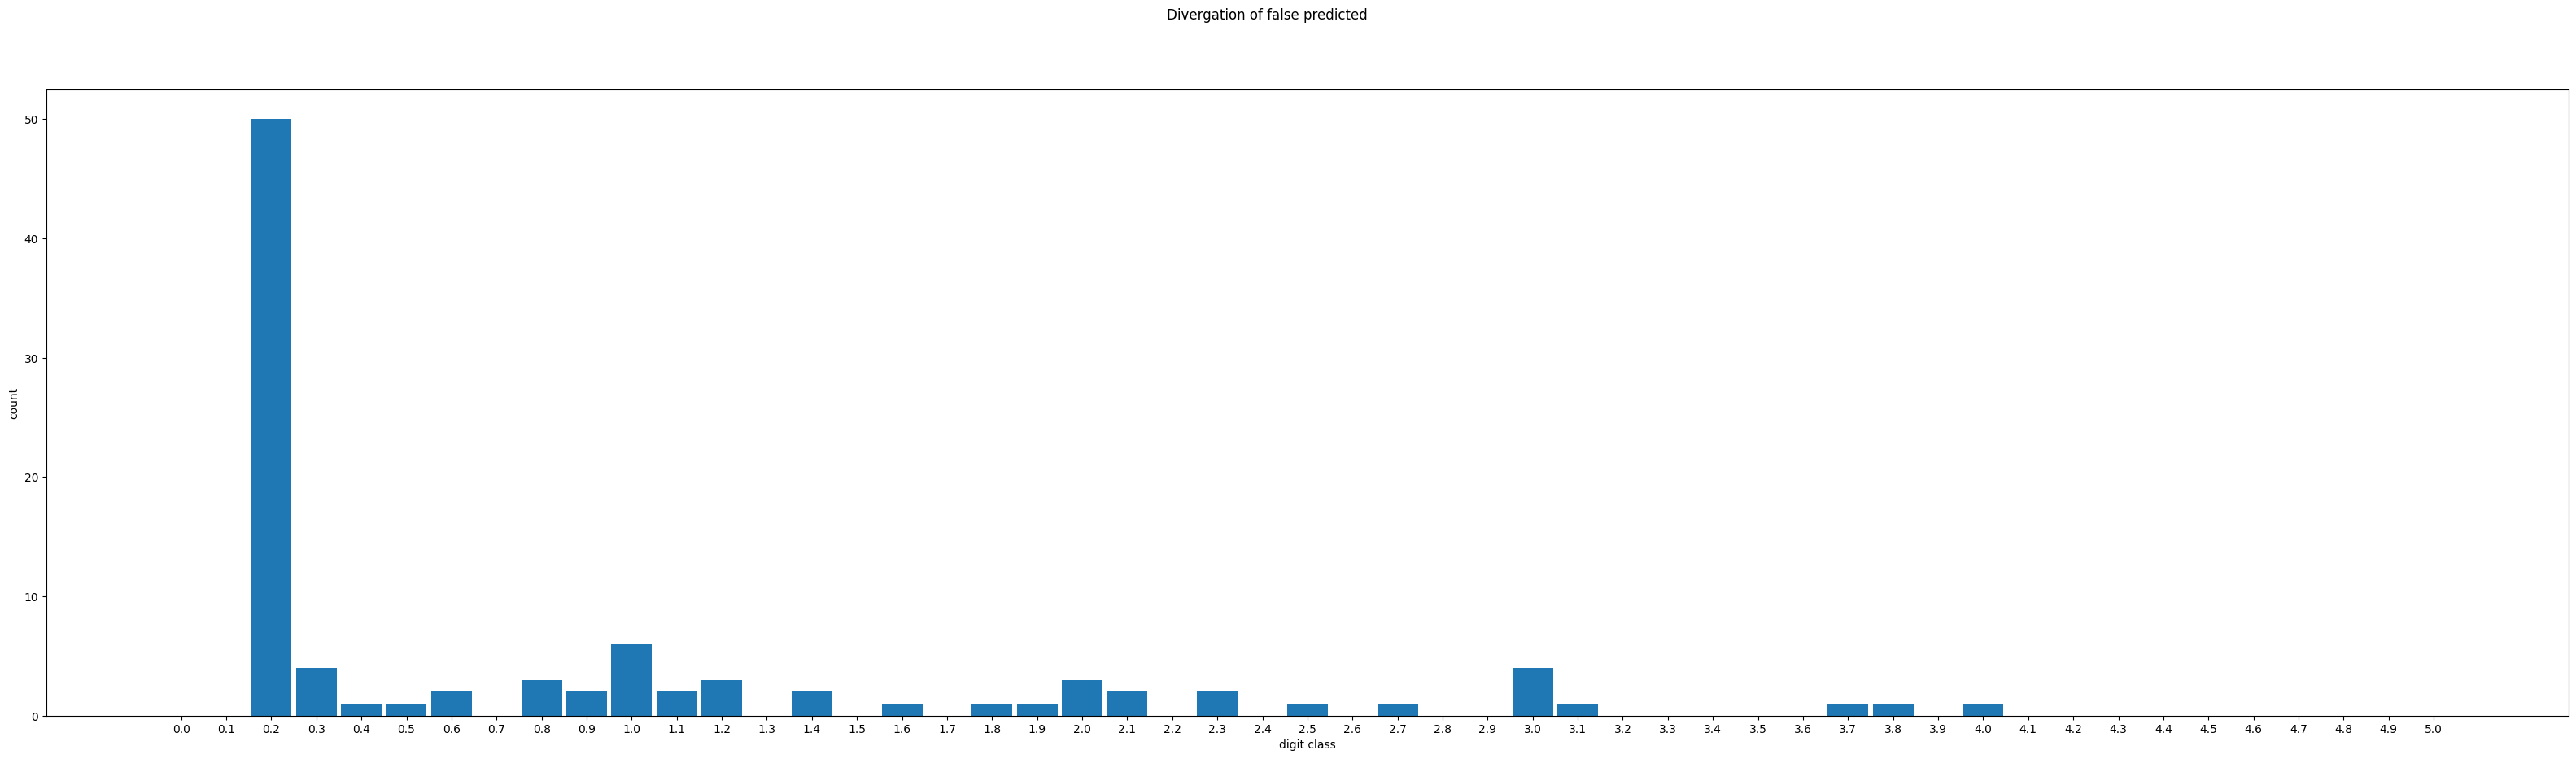

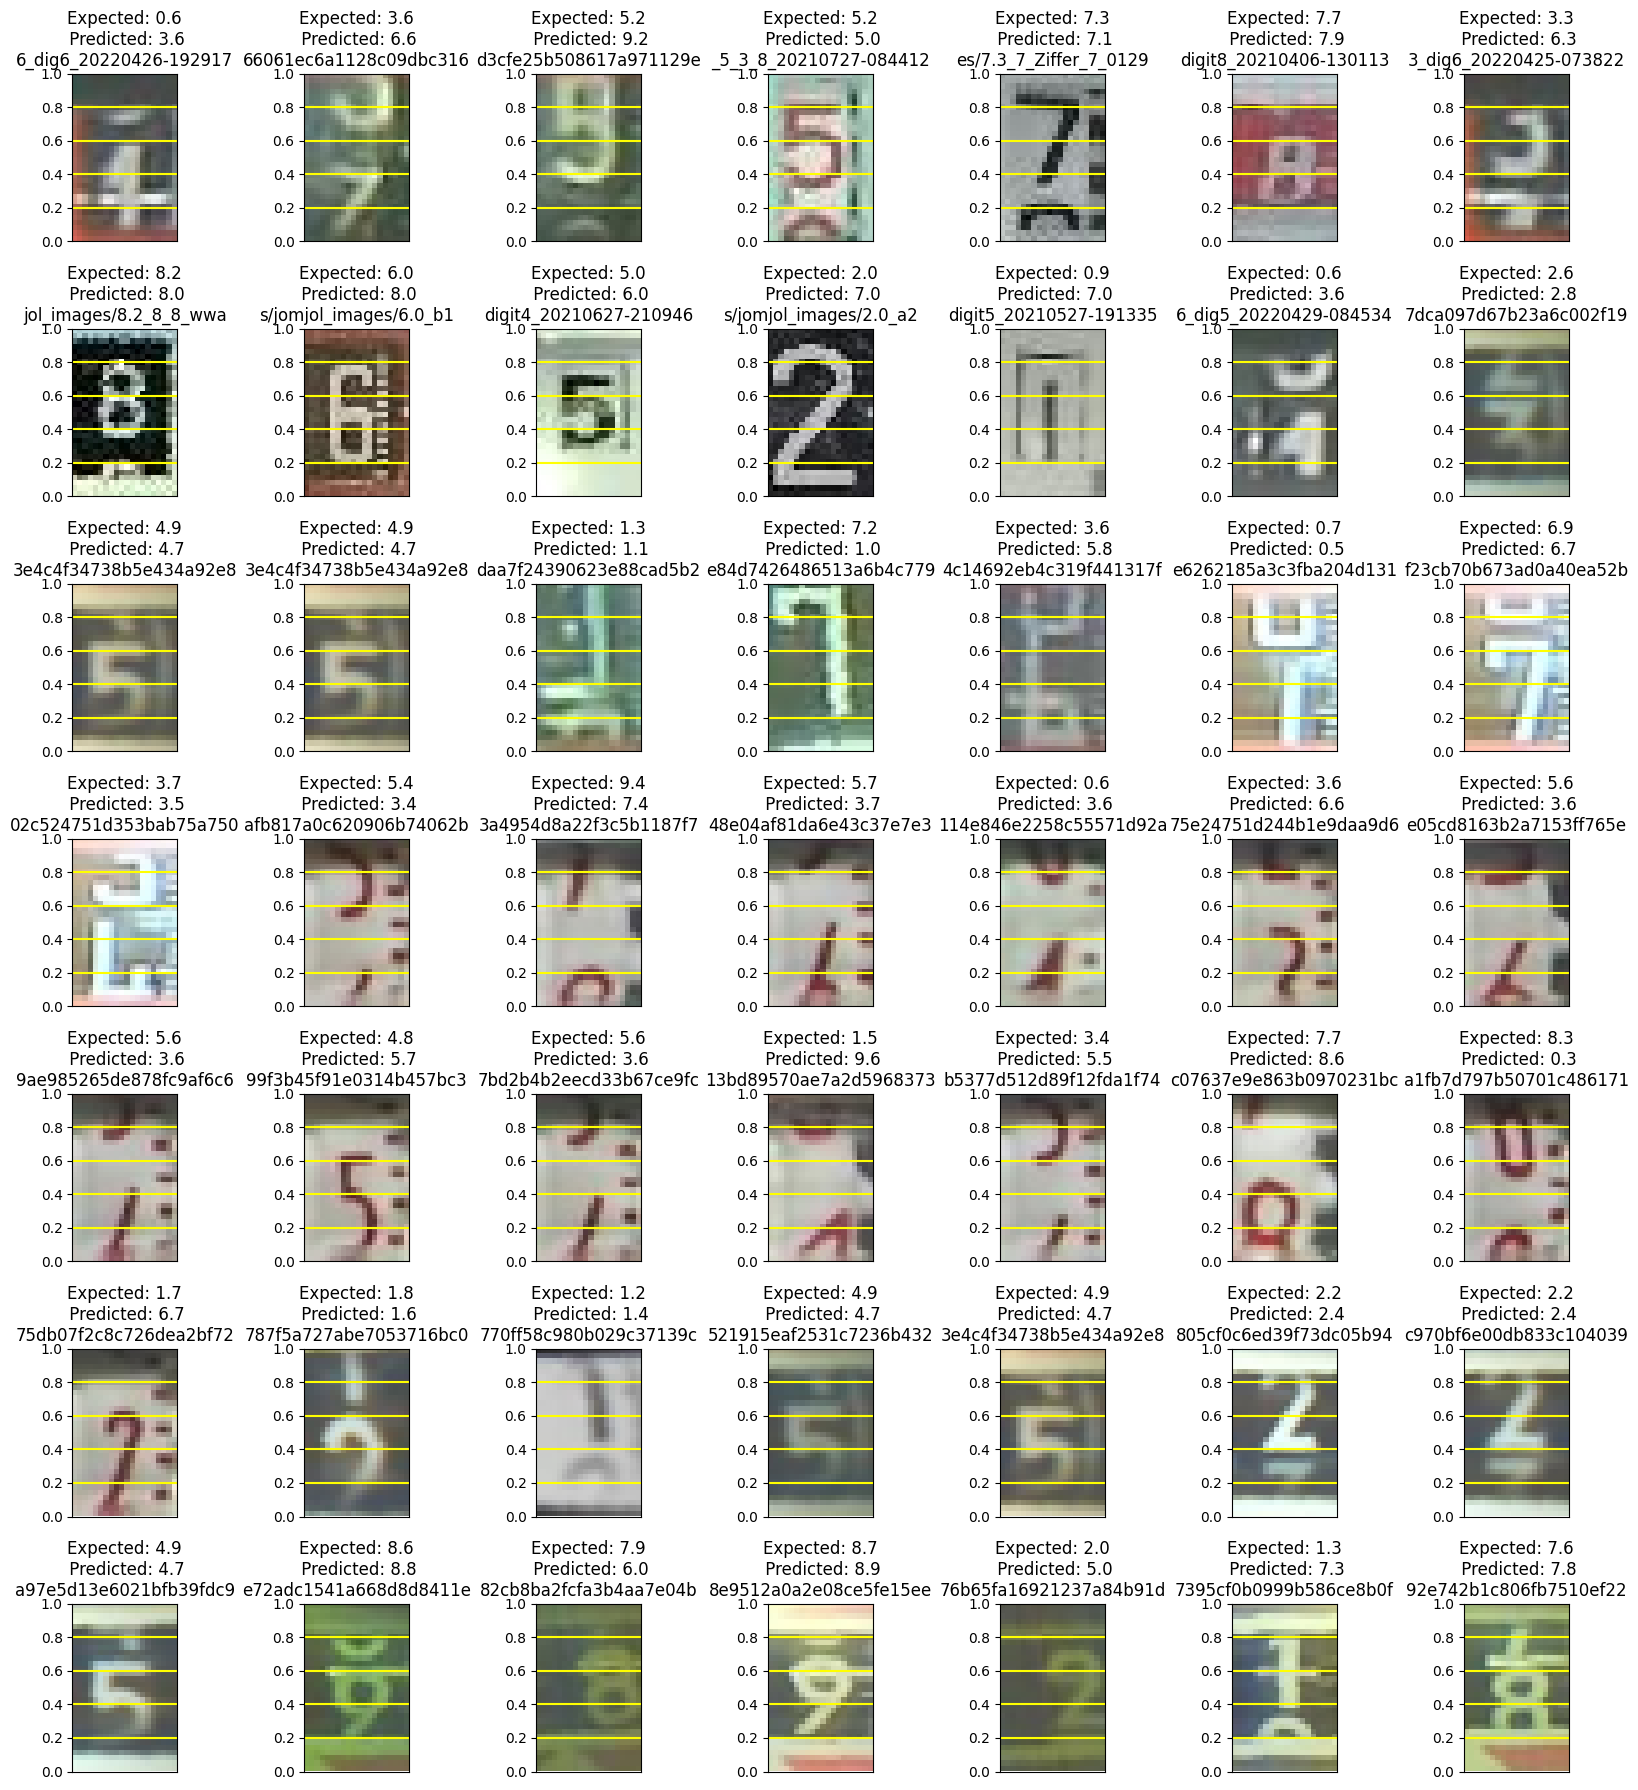

In [6]:
#model = keras.models.load_model(output_tmp_dir + model_filename + '_best.keras')
false_predicted_files = predict_meter_digits(model, x_data=xz_data, y_data=yz_data, f_data=fz_data, 
                                            max_delta=0.11)
fpf = pd.DataFrame(false_predicted_files)

# the csv can be used with collectmeterdigits to fix labels
# python3 -m collectmeterdigits --labelfile=output/tmp/dig-class100-s1_false_predicted.csv
fpf.to_csv(output_tmp_dir + model_filename + '_false_predicted.csv')

In [ ]:
from b2n.models.prune_quantize import prune, quantization_default
from  tensorflow import keras

# prune the model
model_pruned = model
# pruning reduces the accurracy 
#model_pruned = prune(model=model, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

# quanitize and save the model
tflite_model = quantization_default(model=model_pruned, 
                            x_train=x_test)
# save the model
filename=output_dir + model_filename  + "_" + date_time + "_q.tflite"                                                 
open( filename, "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/tmpzo7oimtl/assets


INFO:tensorflow:Assets written to: /var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/tmpzo7oimtl/assets
